## Деревья решений и метод ближайших соседей

 Импортируем библиотеки

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

### Критерии качества разбиения в задаче классификации

- **Энтропия**.*Энтропия Шеннона* определяется для системы с $N$ возможными состояниями следующим образом:$$S=−∑_{i=1}^Np_ilog_2⁡p_i,$$ где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. Это очень важное понятие, используемое в физике, теории информации и других областях. Опуская предпосылки введения (комбинаторные и теоретико-информационные) этого понятия, отметим, что, интуитивно, энтропия соответствует степени хаоса в системе. Чем выше [энтропия](https://habrahabr.ru/post/171759/), тем менее упорядочена система и наоборот.
Поскольку *энтропия* – по сути степень хаоса (или неопределенности) в системе, уменьшение энтропии называют **приростом информации.** Формально прирост информации (**information gain, IG**) при разбиении выборки по признаку $Q$ определяется как

$$IG(Q)=S_O−∑_{i=1}^q\frac{N_i}{N}S_i$$,

где $q$ – число групп после разбиения, $N_i$ – число элементов выборки, у которых признак $Q$ имеет $i$-ое значение.

- **Неопределенность Джини** *(Gini impurity):* $$G=1−∑_k(p_k)^2.$$ Максимизацию этого критерия можно интерпретировать как максимизацию числа пар объектов одного класса, оказавшихся в одном поддереве. Подробнее об этом (как и обо многом другом) можно узнать из [репозитория](https://github.com/OlenaNN/ml-course-hse) Евгения Соколова. Не путать с индексом Джини! 

- **Ошибка классификации** *(misclassification error):* $$E=1−max_kp_k.$$ На практике ошибка классификации почти не используется, а неопределенность Джини и прирост информации работают почти одинаково.

В случае задачи бинарной классификации ($p_+$ – вероятность объекта иметь метку +) энтропия и неопределенность Джини примут следующий вид:


$$S=−p+log_2⁡p_+−p−log_2⁡p−=−p+log_2⁡p+−(1−p_+)log_2⁡(1−p_+);$$

$$G=1−p_+^2−p_−^2=1−p_+^2−(1−p_+)^2=2p+(1−p_+).$$

Когда мы построим графики этух двух функций от аргумента p+, то увидим, что график энтропии очень близок к графику удвоенной неопределенности Джини, и поэтому на практике эти два критерия "работают" почти одинаково.

Отрисовка картинки

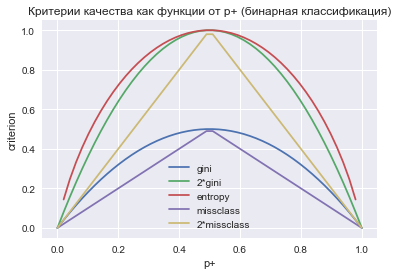

In [2]:
plt.rcParams['figure.figsize'] = (6,4)
xx = np.linspace(0,1,50)
plt.plot(xx, [2 * x * (1-x) for x in xx], label='gini')
plt.plot(xx, [4 * x * (1-x) for x in xx], label='2*gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
plt.plot(xx, [1 - max(x, 1-x) for x in xx], label='missclass')
plt.plot(xx, [2 - 2 * max(x, 1-x) for x in xx], label='2*missclass')
plt.xlabel('p+')
plt.ylabel('criterion')
plt.title('Критерии качества как функции от p+ (бинарная классификация)')
plt.legend();

### Пример

Рассмотрим пример применения дерева решений из библиотеки *Scikit-learn* для синтетических данных. Два класса будут сгенерированы из двух нормальных распределений с разными средними.

### Код для генерации данных

**`np.r_[...]`**

This is a simple way to build up arrays quickly. There are two use cases.

1. If the index expression contains comma separated arrays, then stack
   them along their first axis.
2. If the index expression contains slice notation or scalars then create
   a 1-D array with a range indicated by the slice notation.
   
Optional character strings placed as the first element of the index
expression can be used to change the output. The strings `'r'` or `'c'` result
in matrix output. If the result is 1-D and `'r'` is specified a 1 x N (row)
matrix is produced. If the result is 1-D and `'c'` is specified, then a N x 1
(column) matrix is produced. If the result is 2-D then both provide the
same matrix result.


In [3]:
# первый класс
np.seed = 7
train_data = np.random.normal(size=(100, 2))#Draw random samples from a normal (Gaussian) distribution
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2),loc=2)] #loc=2 означает, что центр распределения=2
train_labels = np.r_[train_labels, np.ones(100)]

In [4]:
#?np.r_

Отобразим данные. Неформально, задача классификации в этом случае – построить какую-то "хорошую" границу, разделяющую 2 класса (красные точки от желтых). Если утрировать, то машинное обучение в этом случае сводится к тому, как выбрать хорошую разделяющую границу. Возможно, прямая будет слишком простой границей, а какая-то сложная кривая, огибающая каждую красную точку – будет слишком сложной и будем много ошибаться на новых примерах из того же распределения, из которого пришла обучающая выборка. Интуиция подсказывает, что хорошо на новых данных будет работать какая-то гладкая граница, разделяющая 2 класса, или хотя бы просто прямая (в n-мерном случае – гиперплоскость).

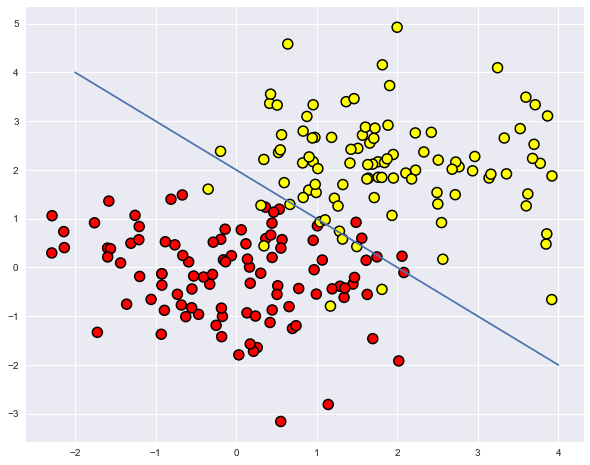

In [5]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, marker='o',
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));

In [6]:
#?plt.scatter

In [7]:
train_data[:, 0].shape

(200,)

In [8]:
train_data[:, 1].shape

(200,)

Попробуем разделить эти два класса, обучив дерево решений. В дереве будем использовать параметр **`max_depth`**, ограничивающий глубину дерева. Визуализируем полученную границу разделения классов.

In [42]:
from sklearn.tree import DecisionTreeClassifier #импортируем необходимый модуль

Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей визуализации.

In [10]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [11]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

Oбучаем дерево. Параметр *`min_samples_split`* указывает, при каком минимальном количестве элементов в узле он будет дальше разделяться



In [12]:
clf_tree.fit(train_data, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [13]:
#?DecisionTreeClassifier

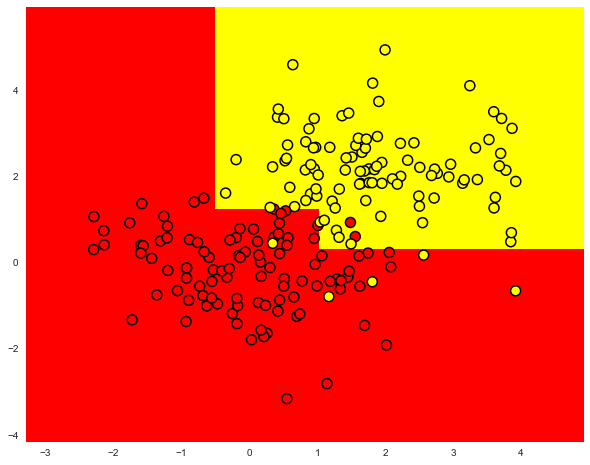

In [14]:
# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);

## Код для отображения дерева

**Инструкция для настройки `graphviz`:** *In my case **(Win10, Anaconda3, Jupyter notebook) I solved the problem by**

- `pip install pydotplus`
- **`pip install graphviz`.**
- **`conda install graphviz`** 
-  after **`conda install graphviz`** I have to add to the **PATH:**  
**`C:\Users\username\Anaconda3\Library\bin\graphviz`**

In [15]:
from sklearn import tree
import pydotplus 
dot_data = tree.export_graphviz(clf_tree, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("simple_tree.pdf") 

True

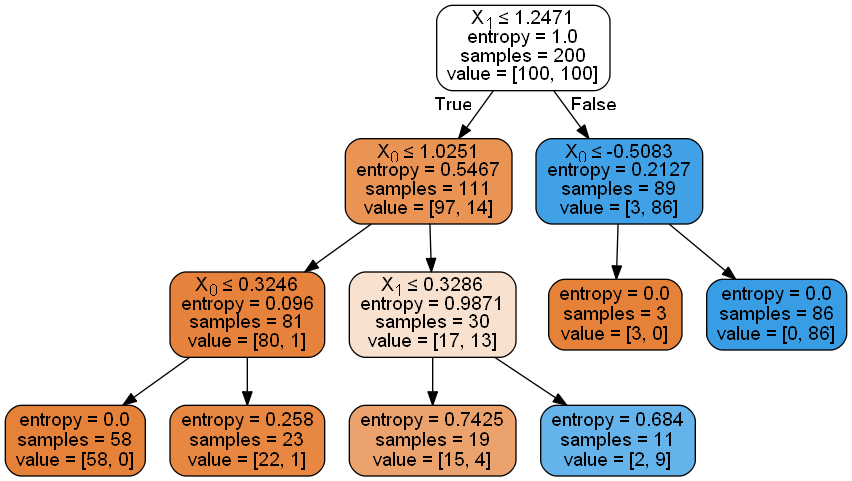

In [16]:
from IPython.display import Image  
dot_data = tree.export_graphviz(clf_tree, out_file=None,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

In [17]:
graph.write_png("simple_tree.png")

True

### Как дерево решений работает с количественными признаками

### Полезные статьи
- [A Simple Guide to Entropy-Based Discretization](http://kevinmeurer.com/a-simple-guide-to-entropy-based-discretization/)
- [Discretization](http://clear-lines.com/blog/post/Discretizing-a-continuous-variable-using-Entropy.aspx)

### Основные параметры дерева

В принципе дерево решений можно построить до такой глубины, чтоб в каждом листе был ровно один объект. Но на практике это не делается (если строится только одно дерево) из-за того, что такое дерево будет переобученным – оно слишком настроится на обучающую выборку и будет плохо работать на прогноз на новых данных. Где-то внизу дерева, на большой глубине будут появляться разбиения по менее важным признакам (например, приехал ли клиент из Саратова или Костромы). Если утрировать, может оказаться так, что из всех 4 клиентов, пришедших в банк за кредитом в зеленых штанах, никто не вернул кредит. Но мы не хотим, чтобы наша модель классификации порождала такие специфичные правила.

Есть два исключения, ситуации, когда деревья строятся до максимальной глубины:

Случайный лес (композиция многих деревьев) усредняет ответы деревьев, построенных до максимальной глубины (почему стоит делать именно так, разберемся позже)
Стрижка дерева (*pruning*). При таком подходе дерево сначала строится до максимальной глубины, потом постепенно, снизу вверх, некоторые вершины дерева убираются за счет сравнения по качеству дерева с данным разбиением и без него (сравнение проводится с помощью кросс-валидации, о которой чуть ниже). Подробнее можно почитать в материалах [репозитория](https://github.com/esokolov/ml-course-hse) Евгения Соколова.

Основные способы борьбы с переобучением в случае деревьев решений:

- искусственное ограничение глубины или минимального числа объектов в листе: построение дерева просто в какой-то момент прекращается;
- стрижка дерева

### Класс DecisionTreeClassifier в Scikit-learn

Основные параметры класса `sklearn.tree.DecisionTreeClassifier`:

- `max_depth` – максимальная глубина дерева
- `max_features` — максимальное число признаков, по которым ищется лучшее разбиение в дереве (это нужно потому, что при большом количестве признаков будет "дорого" искать лучшее (по критерию типа прироста информации) разбиение среди всех признаков)
- `min_samples_leaf` – минимальное число объектов в листе. У этого параметра есть понятная интерпретация: скажем, если он равен 5, то дерево будет порождать только те классифицирующие правила, которые верны как минимум для 5 объектов

Параметры дерева надо настраивать в зависимости от входных данных, и делается это обычно с помощью кросс-валидации, про нее чуть ниже.


### Дерево решений в задаче регрессии

При прогнозировании количественного признака идея построения дерева остается та же, но меняется критерий качества:

Дисперсия вокруг среднего: $$D=\frac{1}{ℓ}∑_{i=1}^ℓ(y_i−\frac{1}{ℓ}∑_{i=1}^ℓy_i)^2,$$
где $ℓ$ – число объектов в листе, $y_i$ – значения целевого признака. Попросту говоря, минимизируя дисперсию вокруг среднего, мы ищем признаки, разбивающие выборку таким образом, что значения целевого признака в каждом листе примерно равны.

### Пример

Сгенерируем данные, распределенные вокруг функции $$f(x)=e^{−x^2}+1.5e^{−(x−2)^2}$$ c некоторым шумом, обучим на них дерево решений и изобразим, какие прогнозы делает дерево.

In [18]:
n_train = 150        
n_test = 1000       
noise = 0.1
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

In [19]:
def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

In [20]:
#?np.ravel()
#?np.random.rand()
#?np.reshape()

In [21]:
X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

In [22]:
from sklearn.tree import DecisionTreeRegressor

In [23]:
reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

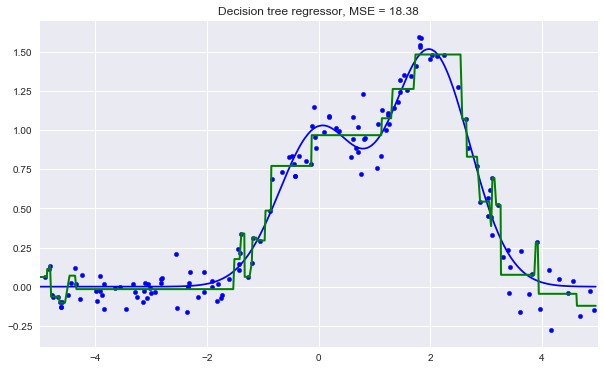

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

### Метод ближайших соседей

Метод ближайших соседей (*k Nearest Neighbors*, или *kNN*) — тоже очень популярный метод классификации, также иногда используемый в задачах регрессии. Это, наравне с деревом решений, один из самых понятных подходов к классификации. На уровне интуиции суть метода такова: посмотри на соседей, какие преобладают, таков и ты. Формально основой метода является гипотеза компактности: если метрика расстояния между примерами введена достаточно удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных.

Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:

- Вычислить расстояние до каждого из объектов обучающей выборки
- Отобрать k объектов обучающей выборки, расстояние до которых минимально
- Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди k ближайших соседей

Под задачу регрессии метод адаптируется довольно легко – на 3 шаге возвращается не метка, а число – среднее (или медианное) значение целевого признака среди соседей.

Примечательное свойство такого подхода – его ленивость. Это значит, что вычисления начинаются только в момент классификации тестового примера, а заранее, только при наличии обучающих примеров, никакая модель не строится. В этом отличие, например, от ранее рассмотренного дерева решений, где сначала на основе обучающей выборки строится дерево, а потом относительно быстро происходит классификация тестовых примеров.

Стоит отметить, что метод ближайших соседей – хорошо изученный подход (в машинном обучении, эконометрике и статистике больше известно, наверное, только про линейную регрессию). Для метода ближайших соседей существует немало важных теорем, утверждающих, что на "бесконечных" выборках это оптимальный метод классификации. Авторы классической книги "The Elements of Statistical Learning" считают kNN теоретически идеальным алгоритмом, применимость которого просто ограничена вычислительными возможностями и проклятием размерностей.


### Метод ближайших соседей в реальных задачах

- В чистом виде **kNN** может послужить хорошим стартом (baseline) в решении какой-либо задачи;
- В соревнованиях *Kaggle* **kNN** часто используется для построения мета-признаков (прогноз *kNN* подается на вход прочим моделям) или в стекинге/блендинге;
- Идея ближайшего соседа расширяется и на другие задачи, например, в рекомендательных системах простым начальным решением может быть рекомендация какого-то товара (или услуги), популярного среди ближайших соседей человека, которому хотим сделать рекомендацию;
- На практике для больших выборок часто пользуются приближенными методами поиска ближайших соседей. [Вот](https://www.youtube.com/watch?v=UUm4MOyVTnE) лекция Артема Бабенко про эффективные алгоритмы поиска ближайших соседей среди миллиардов объектов в пространствах высокой размерности (поиск по картинкам).


Качество классификации/регрессии методом ближайших соседей зависит от нескольких параметров:

- число соседей
- метрика расстояния между объектами (часто используются метрика Хэмминга, евклидово расстояние, косинусное расстояние и расстояние Минковского). Отметим, что при использовании большинства метрик значения признаков надо масштабировать. Условно говоря, чтобы признак "Зарплата" с диапазоном значений до 100 тысяч не вносил больший вклад в расстояние, чем "Возраст" со значениями до 100.
- веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос")


### Класс `KNeighborsClassifier` в `Scikit-learn`

Основные параметры класса `sklearn.neighbors.KNeighborsClassifier`:

- `weights`: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера) или другая определенная пользователем функция
- `algorithm` (опционально): "brute", "ball_tree", "KD_tree", или "auto". В первом случае ближайшие соседи для каждого тестового примера считаются перебором обучающей выборки. Во втором и третьем — расстояние между примерами хранятся в дереве, что ускоряет нахождение ближайших соседей. В случае указания параметра "auto" подходящий способ нахождения соседей будет выбран автоматически на основе обучающей выборки.
- `leaf_size` (опционально): порог переключения на полный перебор в случае выбора BallTree или KDTree для нахождения соседей
- `metric`: "minkowski", "manhattan", "euclidean", "chebyshev" и другие


### Выбор параметров модели и кросс-валидация

Главная задача обучаемых алгоритмов – их способность обобщаться, то есть хорошо работать на новых данных. Поскольку на новых данных мы сразу не можем проверить качество построенной модели (нам ведь надо для них сделать прогноз, то есть истинных значений целевого признака мы для них не знаем), то надо пожертвовать небольшой порцией данных, чтоб на ней проверить качество модели.

Чаще всего это делается одним из 2 способов:

- отложенная выборка (held-out/hold-out set). При таком подходе мы оставляем какую-то долю обучающей выборки (как правило от 20% до 40%), обучаем модель на остальных данных (60-80% исходной выборки) и считаем некоторую метрику качества модели (например, самое простое – долю правильных ответов в задаче классификации) на отложенной выборке.
- кросс-валидация (cross-validation, на русский еще переводят как скользящий или перекрестный контроль). Тут самый частый случай – K-fold кросс-валидация


Модель обучается $K$ раз на разных $(K−1)$ подвыборках исходной выборки, а проверяется на одной подвыборке (каждый раз на разной).
Получаются $K$ оценок качества модели, которые обычно усредняются, выдавая среднюю оценку качества классификации/регрессии на кросс-валидации.

Кросс-валидация дает лучшую по сравнению с отложенной выборкой оценку качества модели на новых данных. Но кросс-валидация вычислительно дорогостоящая, если данных много.

Кросс-валидация – очень важная техника в машинном обучении (применяемая также в статистике и эконометрике), с ее помощью выбираются гиперпараметры моделей, сравниваются модели между собой, оценивается полезность новых признаков в задаче и т.д. Более подробно можно почитать, например, [тут](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part1.html) у Sebastian Raschka или в любом классическом учебнике по машинному (статистическому) обучению

### Примеры применения

**Деревья решений** и **метод ближайших соседей** в задаче прогнозирования оттока клиентов телеком-оператора

Считаем данные в `DataFrame` и проведем предобработку. Штаты пока сохраним в отдельный объект `Series`, но удалим из датафрейма. Первую модель будем обучать без штатов, потом посмотрим, помогают ли они.

In [58]:
df=pd.read_csv('e:/Machine_Learning/datasets/telecom_churn.csv')
df['International plan'] = pd.factorize(df['International plan'])[0]
df['Voice mail plan'] = pd.factorize(df['Voice mail plan'])[0]
df['Churn'] = df['Churn'].astype('int')
states = df['State']
y = df['Churn']
df.drop(['State', 'Churn'], axis=1, inplace=True)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 18 columns):
Account length            3333 non-null int64
Area code                 3333 non-null int64
International plan        3333 non-null int64
Voice mail plan           3333 non-null int64
Number vmail messages     3333 non-null int64
Total day minutes         3333 non-null float64
Total day calls           3333 non-null int64
Total day charge          3333 non-null float64
Total eve minutes         3333 non-null float64
Total eve calls           3333 non-null int64
Total eve charge          3333 non-null float64
Total night minutes       3333 non-null float64
Total night calls         3333 non-null int64
Total night charge        3333 non-null float64
Total intl minutes        3333 non-null float64
Total intl calls          3333 non-null int64
Total intl charge         3333 non-null float64
Customer service calls    3333 non-null int64
dtypes: float64(8), int64(10)
memory usage: 468.8

Выделим 70% выборки (`X_train, y_train`) под обучение и 30% будут отложенной выборкой (`X_holdout, y_holdout`). отложенная выборка никак не будет участвовать в настройке параметров моделей, на ней мы в конце, после этой настройки, оценим качество полученной модели. Обучим 2 модели – дерево решений и kNN, пока не знаем, какие параметры хороши, поэтому наугад: глубину дерева берем 5, число ближайших соседей – 10.

In [60]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

In [61]:

X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size=0.3,random_state=17)

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

#tree.fit(X_train, y_train)
#knn.fit(X_train, y_train)

In [62]:
tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [63]:
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [67]:
#X_train

In [68]:
#y_train

In [66]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [69]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')